In [1]:
# This is a configuration step for the exercise. Please run it before the simulation code! 
%matplotlib notebook 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Simple finite difference solver 
# Acoustic wave equation  p_tt = c^2 p_xx + src
# 2-D regular grid

nx = 300     # grid points in x - 500
nz = nx     # grid points in z - 500
# Note: regular 2D grid, dz = dx
nt = 302     # number of time steps
dx = 1.0     # grid point distance in x-direction
dz   = dx    # grid point distance in z-direction
dt = 0.001    # Time step
c0 = 580.0   # velocity (can be an array) - 580
isx = 150    # source index x - 250
isz = isx // 2 # source index z - 250
irx  = 200          # receiver location in grid in x-direction
irz  = irx          # receiver location in grid in z-direction
#ist = 25     # shifting of source time function
f0 = 50.0     # dominant frequency of source (Hz)
t0   = 4. / f0 # source time shift
isnap = 50    # snapshot frequency
#T = 1.0 / f0  # dominant period
nop = 3      # length of operator

print('Source frequency =', f0, 'Hz')

# CFL Stability Criterion
# -----------------------
eps  = c0 * dt / dx # epsilon value
print('Stability criterion =', eps)

# Model type, available are "homogeneous", "fault_zone",
# "surface_low_velocity_zone", "random", "topography",
# "slab"
model_type = "homogeneous"

# Receiver locations
#irx = np.array([50,60, 70, 80, 90])
#irz = np.array([5, 5, 5, 5, 5])
#seis = np.zeros((len(irx), nt))

# Initialize pressure at different time steps and the second
# derivatives in each direction
p = np.zeros((nz, nx, nt))
#pold = np.zeros((nz, nx))
#pnew = np.zeros((nz, nx))
d2px = np.zeros((nz, nx, nt))
d2pz = np.zeros((nz, nx, nt))


Source frequency = 50.0 Hz
Stability criterion = 0.58


In [3]:
# Initialize velocity model (the fun bit!)
c = np.zeros((nz, nx))

if model_type == "homogeneous":
    c += c0
elif model_type == "fault_zone":
    c += c0
    c[:, nx // 2 - 5: nx // 2 + 5] *= 0.8    
elif model_type == "surface_low_velocity_zone":
    c += c0
    c[1:10,:] *= 0.8
elif model_type == "random":
    pert = 0.4
    r = 2.0 * (np.random.rand(nz, nx) - 0.5) * pert
    c += c0 * (1 + r)   
elif model_type == "topography":
    c += c0
    c[0 : 10, 10 : 50] = 0                         
    c[0 : 10, 105 : 115] = 0                       
    c[0 : 30, 145 : 170] = 0
    c[10 : 40, 20 : 40]  = 0
    c[0 : 15, 50 : 105] *= 0.8    
elif model_type == "slab":
    c += c0
    c[110 : 125, 0 : 125] = 1.4 * c0
    for i in range(110, 180):
        c[i , i-5 : i + 15 ] = 1.4 * c0
else:
    raise NotImplementedError
    
cmax = c.max()

In [4]:
# Source time function Gaussian, nt + 1 as we loose the last one by diff
#src = np.empty(nt + 1)
#for it in range(nt):
#    src[it] = np.exp(-1.0 / T ** 2 * ((it - ist) * dt) ** 2)
# Take the first derivative
#src = np.diff(src) / dt
#src[nt - 1] = 0

# Initialize Empty Seismogram
# ---------------------------
seis = np.zeros(nt)

# Initialize Source Time Function 
# -------------------------
# Source time function (Gaussian)
# -------------------------------
src  = np.zeros(nt)
time = np.linspace(0 * dt, nt * dt, nt)
# 1st derivative of a Gaussian
src  = -2. * (time - t0) * (f0 ** 2) * (np.exp(-1.0 * (f0 ** 2) * (time - t0) ** 2))

In [5]:
# Initialize Grid
x    = np.arange(nx)
x    = x * dx             # coordinate in x-direction
z    = np.arange(nz)
z    = z * dz             # coordinate in z-direction

# Analytical Solution 
# -------------------
G    = time * 0.
r    = np.sqrt((x[isx] - x[irx]) ** 2 + (z[isz] - z[irz]) ** 2)

for it in range(nt): # Calculate Green's function
    if ((time[it] - np.abs(x[irx] - x[isx]) / c0) >= 0):
        G[it] = (1. / (2 * np.pi * c0 ** 2))         * (1. / np.sqrt((time[it] ** 2) - (r ** 2 / (c0 ** 2))))
Gc   = np.convolve(G, src * dt)
Gc   = Gc[0:nt]
lim  = Gc.max() # get limit value from maximum amplitude of analytical solution

<IPython.core.display.Javascript object>


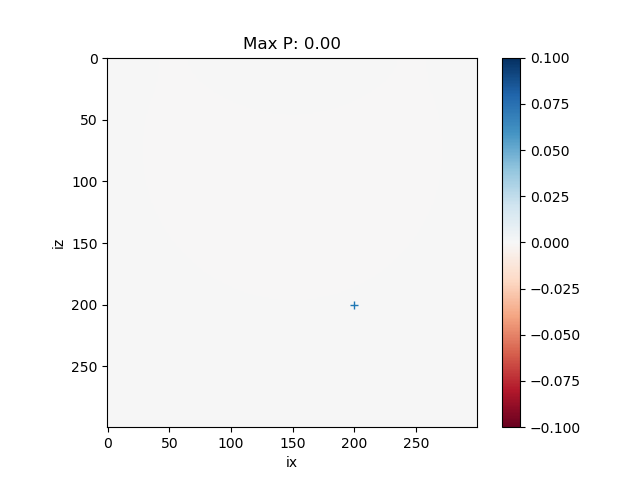

Courant Criterion eps :
0.58


In [6]:
# Plot preparation

v = max([np.abs(src.min()), np.abs(src.max())])
# Initialize animated plot
pnew=p[:,:,0]
image = plt.imshow(pnew, interpolation='nearest', animated=True,
                   vmin=-lim, vmax=+lim, cmap=plt.cm.RdBu)


# Plot the receivers
#for x, z in zip(irx, irz):
#    plt.text(x, z, '+')
plt.plot(irx,irz,'+')
#plt.text(isx, isz, 'o')
plt.colorbar()
plt.xlabel('ix')
plt.ylabel('iz')


plt.ion()
#plt.show(block=False)

# required for seismograms
#ir = np.arange(len(irx))

# Output Courant criterion
print("Courant Criterion eps :")
print(cmax*dt/dx)

In [7]:
# Time extrapolation
for it in range(nt-1):
    if nop==3:
        # calculate partial derivatives, be careful around the boundaries
#        for i in range(1, nx - 1):
#            pxx[:, i, :] = p[:,i-1,:] - 2 * p[:,i,:] + p[:,i+1,:]
#        for j in range(1, nz - 1):
#            pzz[j, :, :] = (p[j - 1, :,:] - 2 * p[j, :,:] + p[j + 1, :,:])
#        for i in range(1, nz - 1):
#            pzz[i, :,:] = (p[i - 1, :,:] - 2 * p[i, :,:] + p[i + 1, :,:]) 
#        for j in range(1, nx - 1):
#            pxx[:, j,:] = (p[:, j - 1,:] - 2 * p[:, j,:] + p[:, j + 1,:])
        for i in range(1, nx - 1):
            d2pz[i, :,it] = (p[i - 1, :,it] - 2 * p[i, :,it] + p[i + 1, :,it]) / dx ** 2 
        for j in range(1, nz - 1):
            d2px[:, j,it] = (p[:, j - 1,it] - 2 * p[:, j,it] + p[:, j + 1,it]) / dz ** 2

    if nop==5:
        # calculate partial derivatives, be careful around the boundaries
        for i in range(2, nx - 2):
            pzz[:, i] = -1./12*p[:,i+2]+4./3*p[:,i+1]-5./2*p[:,i]+4./3*p[:,i-1]-1./12*p[:,i-2]
        for j in range(2, nz - 2):
            pxx[j, :] = -1./12*p[j+2,:]+4./3*p[j+1,:]-5./2*p[j,:]+4./3*p[j-1,:]-1./12*p[j-2,:]
                    
            
#    pxx /= dx ** 2
#    pzz /= dx ** 2

    # Time Extrapolation
    # ------------------
    p[:,:,it+1] = 2 * p[:,:,it] - p[:,:,it-1] + (c ** 2) * (dt ** 2) * (d2pz[:,:,it] + d2px[:,:,it])
    
    # Add Source Term at isz and isx
    # ------------------------------
    # Absolute pressure w.r.t analytical solution
    p[isz, isx,it+1] = p[isz, isx,it+1] + src[it] / (dx * dz) * (dt ** 2)
    pnew=p[:,:,it]
    # Plot every isnap-th iteration
    if it % isnap == 0:    # you can change the speed of the plot by increasing the plotting interval
        
        plt.title("Max P: %.2f" % p.max())
        image.set_data(pnew)
        plt.gcf().canvas.draw()

#    pold, p = p, pnew
    # Output Seismogram
    # -----------------
    seis[it] = p[irz, irx,it]
    
    # Save seismograms
#    seis[ir, it] = p[irz[ir], irx[ir],it]

The cell below allows you to plot source time function, seismic velocites, and the resulting seismograms in windows inside the notebook. Remember to rerun after you simulated again!

<IPython.core.display.Javascript object>


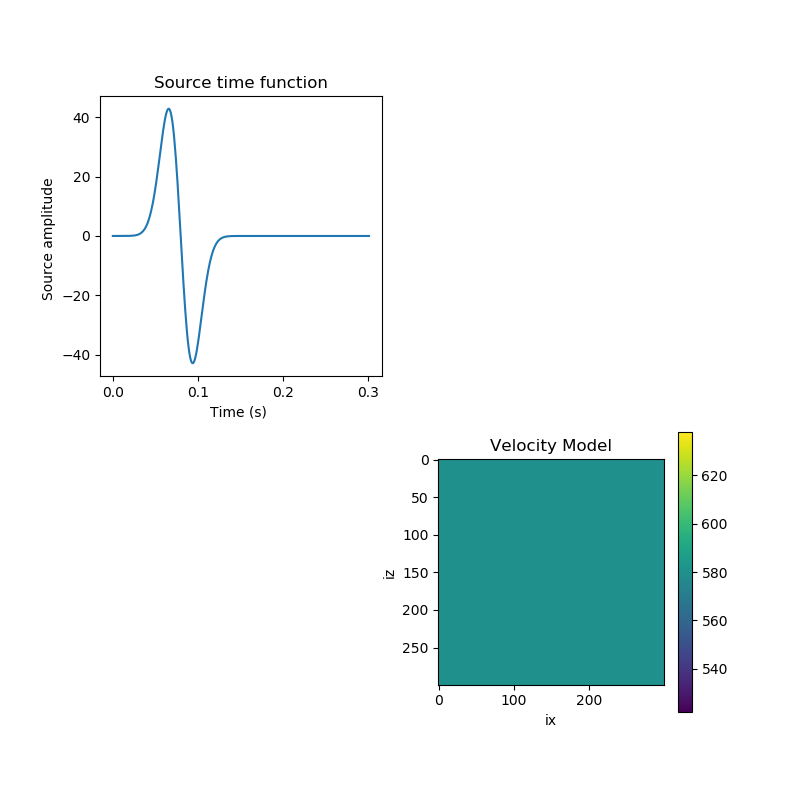

In [8]:
# Plot the source time function and the seismograms 

plt.ioff()
plt.figure(figsize=(8, 8))

plt.subplot(221)
time = np.arange(nt) * dt
plt.plot(time, src)
plt.title('Source time function')
plt.xlabel('Time (s) ')
plt.ylabel('Source amplitude ')

#plt.subplot(222)
#ymax = seis.ravel().max()  
#for ir in range(len(seis)):
#    plt.plot(time, seis[ir, :] + ymax * ir)
#    plt.xlabel('Time (s)')
#    plt.ylabel('Amplitude')

#plt.subplot(223)
#ymax = seis.ravel().max()
#for ir in range(len(seis)):
#    plt.plot(time, seis[ir, :] + ymax * ir)
#    plt.xlabel('Time (s)')
#    plt.ylabel('Amplitude')

plt.subplot(224)
# The velocity model is influenced by the Earth model above
plt.title('Velocity Model')
plt.imshow(c)
plt.xlabel('ix')
plt.ylabel('iz')
plt.colorbar()

plt.show()

<IPython.core.display.Javascript object>


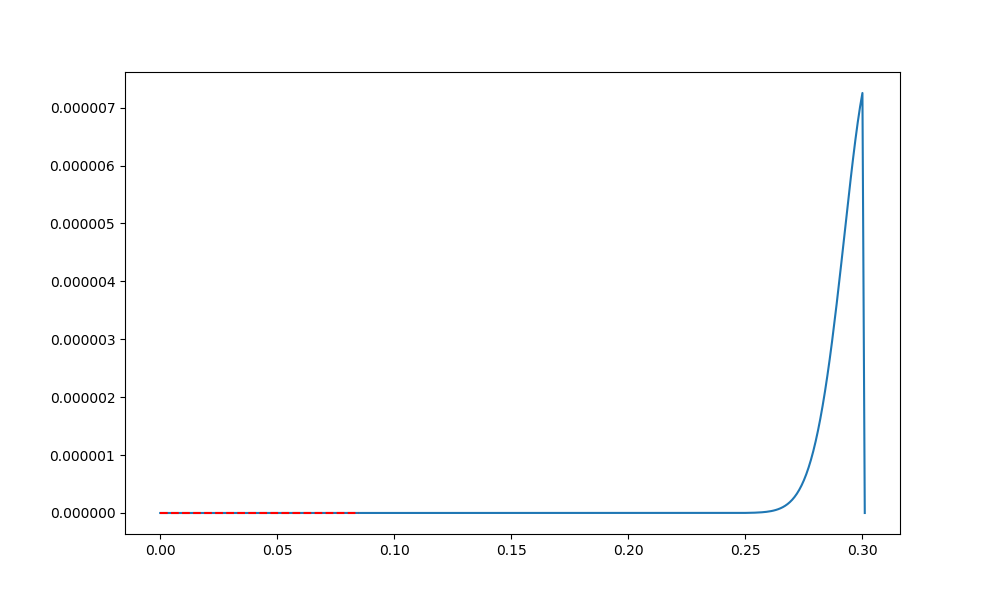

In [9]:
plt.ion
fig3 = plt.figure(figsize=(10, 6))
plt.plot(time, seis)
plt.plot(time,Gc,'r--')
plt.show()